In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
%matplotlib inline
from scipy.stats import norm, multivariate_normal

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp

from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Las estrellas de este notebook
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier

from sklearn import datasets


# El todo es mas que la suma de sus partes

Como vimos en la clase del Martes 19, los DT tienen algunas contras muy fuertes: son inestables, muy propensos al overfitteo y no suelen llegar al mejor resultado posible. En general, todos los algoritmos que vimos tienen sus limitaciones que afectan su rendimiento a la hora de clasificar o interpolar.

Muchos de los problemas que estuvimos viendo a lo largo de la materia pueden resolverse con el viejo adagio: [more cowbell](https://vimeo.com/257364428). En efecto, los llamados algoritmos de _ensemble_ consisten en juntar varios predictores y utilizar todos sus outputs para asignar una clase o un valor a la medicion.

Sin embargo, estos metodos no son perfectos. De hecho, hay que tener cuidado con que algoritmos estamos combinando. Si los algoritmos que tenemos tienen el mismo tipo de problemas, estos se van a acrecentar en el ensemble. Un buen tip es entonces usar siempre algoritmos independientes, sea en los datos que utilizaron en el entrenamiento o en el enfoque que tienen.

El plan de este notebook es ver tres ejemplos:

*   Un ejemplo de utilizar algoritmos muy diferentes en los mismos datos: VotingClassifier.
*   Un ejemplo de utilizar distintos datos: BaggingClassifier.
*   Un ejemplo particular del BaggingClassifier: RandomForest.




Dentro de los llamados algoritmos de _ensemble_, vamos a ver tres: VotingClassifier, BaggingClassifier y RandomForestClassifier. 

# Voting Classifier

Este tipo de algoritmos agarran predictores ya entrenados, por separado, y utilizan estas predicciones como votos. A una determinada medicion se le asigna la clase con la mayor cantidad de votos.

Para ver un ejemplo, volvamos al dataset make_moons que vimos en el contexto de SVC.

Importamos, separamos en Train y Test y entrenamos tres algoritmos distintos y su combinacion.

In [0]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [9]:

log_clf = LogisticRegression(solver="liblinear", random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('tree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gi...
                                        

El VotingClassifier tiene como input la opcion voting. Voting='hard' usa las asignaciones de la clase mientras que 'soft' usa las predicciones de la probabilidad.

In [10]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf_hard, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.888
VotingClassifier 0.896
VotingClassifier 0.92


Vemos que el ambos VotingClassifier resultan mejores que cada uno de los clasificadores que lo componen. El segundo es con voting="soft" y es claramente mejor que el anterior. Veamos como se ve graficamente.


In [0]:
#Este es el rango de X e Y que se ve bien para nuestro dataset
DEFAULT_AXIS=[-1.5, 2.5, -1, 1.5]

def plot_dataset(X, y, axes=DEFAULT_AXIS):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes=DEFAULT_AXIS, plot_sv=False, plot_cont=True):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    #y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    # if plot_cont:
    #     plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    # if plot_sv:
    #     try:
    #         svs = clf[:-1].inverse_transform(clf.steps[-1][1].support_vectors_)
    #         plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    #     except:
    #         print("LinearSVC no guarda los Support Vectors, para eso us SVC con kernel='linear'")

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

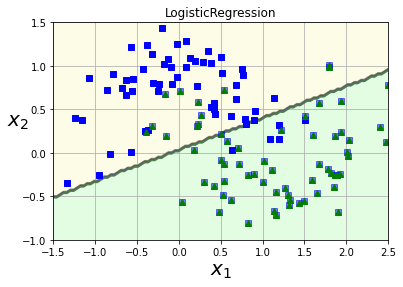

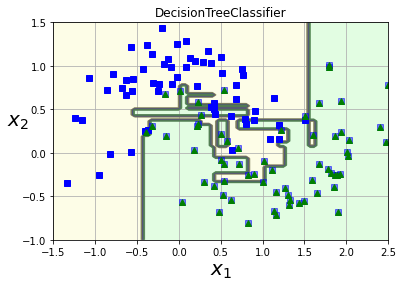

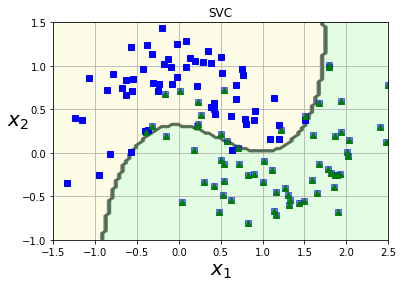

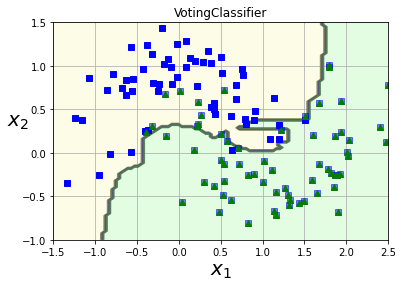

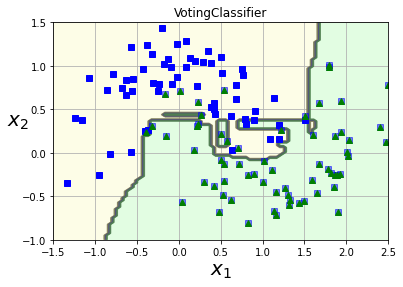

In [13]:
for clf in (log_clf, tree_clf, svm_clf, voting_clf_hard, voting_clf_soft):
    #plot_predictions(clf)
    plt.title(clf.__class__.__name__)
    plot_decision_boundary(clf,X_test,y_test)
    plot_dataset(X_test,y_test)
    plt.show()

# Bagging and Pasting

Estos algoritmos agarran un tipo de algoritmo y lo entrenan sobre distintos subconjuntos de los datos, elegidos al azar, y luego utiliza el conjunto de predicciones para hacer una asignacion.

La diferencia entre bagging y pasting es el sampleo de los datos. El sampleo es el siguiente.



1.   Selecciono un predictor.
2.   Elijo una medicion al azar y se la entrego.
3.   Si estoy en bagging, "repongo la medicion", si es en pasting la saco de mi dataset (por ahora).
4.   Extraigo una nueva medicion.
5.   Repito hasta tener un dataset sampleado de cierto tamaño.
6.   Repongo todo el dataset y repito para otro predictor.

Apliquemoslo con make_moons. En la implementacion de scikit-learn, se permite hacer Bagging de muchas copias de un mismo estimador (es decir, todos los estimadores en el Bagging deben ser del mismo algoritmo). Si el algoritmo lo permite se utiliza por defecto la probabilidad. Si no lo permite, se utiliza la prediccion.

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))


0.904


Los parametros del BaggingClassifier son:

*   n_estimators: el numero de predictores del determinado algoritmo.
*   boostrap: si reemplaza o no la muestra.
*   n_jobs: cuantos nucleos utiliza.
*   max_samples: la maxima cantidad de muestras por predictor.
*   max_features: la maxima cantidad de features por predictor
*   boostrap_features: Si reemplazo o no los features si sampleo en ellos.




Por defecto, el BaggingClassifier samplea $N$ muestras, donde $N$ es el tamanio de nuestro dataset de entrenamiento. Sin embargo, debido al reemplazo, las muestras que utiliza no son las mismas para cada predictor. Ademas, por defecto utiliza todos los features. Si uno utiliza todo el conjunto de entrenamiento pero samplea con reemplazo en los features se llama Random Subspaces. Samplear todo a la vez se llama RandomPatches.

La opcion Out of Bag score permite utilizar las samples que no se utilizaron para entrenar para evaluar el rendimiento del algoritmo. 


In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

Vemos que se parece bastante al accuracy_score que vimos antes. En particular, podemos tambien obtener la funcion de decision del ensemble en este conjunto. Noten que estoy utilizando el conjunto de entrenamiento para evaluar mi ensemble antes de ir al conjunto de testeo.

In [17]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

Dicho mal y pronto, BaggingClassifier viene con un CV score incorporado.

Veamos ahora la diferencia con usar un unico DT:

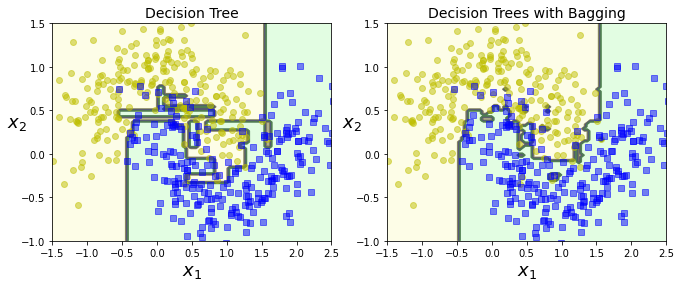

In [18]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

A ojo, aunque la precision no es mucho mayor, la superficie es mucho mas regular, lo cual lo hace mucho menos propenso al overfitting. Esto sucede usualmente al pasar a metodos de Ensemble.


# Random Forest

Un RandomForest es un _ensemble_ de DTs entrenados con Bagging, donde cada nodo elige un conjunto al azar de features para decidir. En particular, esta optimizado para DTs, por lo que es mas eficiente que poner un _ensemble_ de DTs en BaggingClassifier.

In [19]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))


0.904


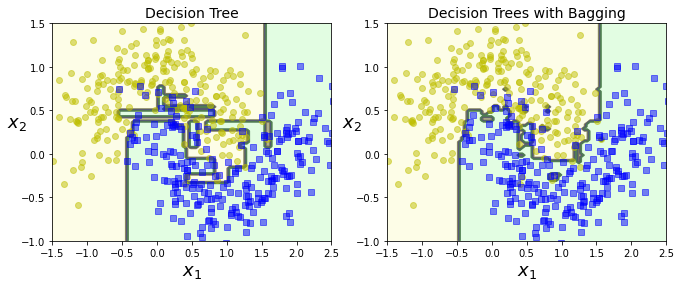

In [20]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

La decision de tomar features al azar en cada nodo vuelve mas irregular la frontera de decision pero reduce un poco mas el error de clasificacion (aca no se ve ese efecto).

Algo bastante interesante es que RandomForest permite ver cual feature es mas importante. Debido a su naturaleza de caja blanca sabemos que para un DT el feature mas importante esta en su raiz. En general, los features mas importantes van a estar lo mas cerca posible de la raiz. 

Por lo tanto, podemos usar el RandomForest como distintas mediciones de importancia de feature y haciendo estadistica sobre los DTs que aparecen en el sacar una estimacion de la importancia de cada feature. En particular, scikit-learn almacena esa informacion tras fittear el conjunto de entrenamiento bajo el atributo feature_importances_.

Veamos esa seleccion de features aplicada a dos datasets: el Iris y el MINST.

In [21]:
iris = datasets.load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Parece que los dos features mas importantes son la longitud y ancho del petalo, sin importar tanto el sepalo. Esto fue lo que vimos a ojo la clase pasada!

In [0]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'plasma',
               interpolation="nearest")
    plt.axis("off")

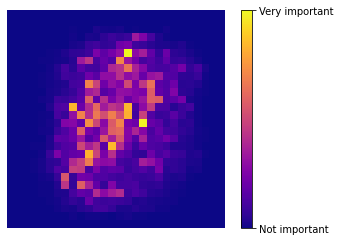

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

Esto permite a los RandomForest no solo ser buenos clasificadores sino tambien buenos preprocesadores. Es decir, entrenando con un RandomForest puedo reducir la dimensionalidad de mis datos.